In [1]:
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt

In [2]:
def unzip_folder(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to: {extract_to}")

In [3]:
unzip_folder("/content/archive.zip","/content/")

Extracted files to: /content/


In [4]:
import os
import shutil

# Paths to the main directories
normal_dir = '/content/Data/NORMAL'
hemorrhagic_dir = '/content/Data/Hemorrhagic'

# Move images from subfolders in NORMAL
for root, dirs, files in os.walk(normal_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Move file to the main NORMAL directory if it’s not already there
        # Check if the file exists in the destination before moving
        destination_path = os.path.join(normal_dir, file)
        if file_path != destination_path and not os.path.exists(destination_path):
            shutil.move(file_path, normal_dir)

# Move images from subfolders in Hemorrhagic
for root, dirs, files in os.walk(hemorrhagic_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Move file to the main Hemorrhagic directory if it’s not already there
        # Check if the file exists in the destination before moving
        destination_path = os.path.join(hemorrhagic_dir, file)
        if file_path != destination_path and not os.path.exists(destination_path):
            shutil.move(file_path, hemorrhagic_dir)

# Now you can remove empty subfolders if desired
for root, dirs, files in os.walk(normal_dir):
    for dir in dirs:
        shutil.rmtree(os.path.join(root, dir))

for root, dirs, files in os.walk(hemorrhagic_dir):
    for dir in dirs:
        shutil.rmtree(os.path.join(root, dir))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

normal_images = len(os.listdir('/content/Data/NORMAL'))
hemorrhagic_images = len(os.listdir('/content/Data/Hemorrhagic'))

print(f"Normal images: {normal_images}, Hemorrhagic images: {hemorrhagic_images}")

# Create the ImageDataGenerator with validation split and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale image pixel values to [0, 1]
    validation_split=0.3,       # Validation split
    width_shift_range=0.2,      # Shift images horizontally by 20%
    height_shift_range=0.2,     # Shift images vertically by 20%
    rotation_range=40,          # Rotate images randomly up to 40 degrees
    zoom_range=0.2,             # Zoom in/out on images by 20%
    shear_range=0.2,            # Shear transformation up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformation
)

# Create the training generator (70% of data)
train_generator = datagen.flow_from_directory(
    '/content/Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='training',      # Use the 'training' subset (70% of data)
    shuffle=True            # Shuffle training data
)

# Create the validation generator (30% of data)
validation_generator = datagen.flow_from_directory(
    '/content/Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='validation',    # Use the 'validation' subset (30% of data)
    shuffle=False           # Do not shuffle validation data
)


Normal images: 4105, Hemorrhagic images: 2689
Found 4757 images belonging to 2 classes.
Found 2037 images belonging to 2 classes.


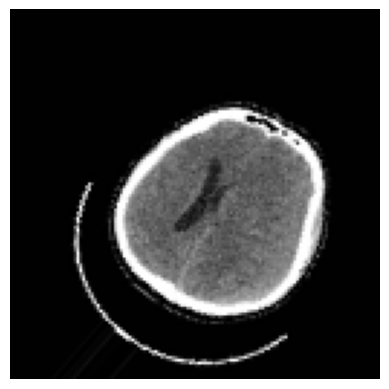

In [6]:
# Get one batch of images and labels from the training generator
images, labels = next(train_generator)

# Get the first image from the batch
image = images[0]

# Display an image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Gets the training data by extracting features and labels from the generator
def extract_features(generator):
    features = []
    labels = []
    # SVM requires 2D data so each image needs to be reshaped
    for _ in range(len(generator)):
        images, batch_labels = next(generator)
        flattened_images = images.reshape(images.shape[0], -1)  # Flatten each image from 3D to 1D (height x width x channels)
        features.extend(flattened_images)
        labels.extend(batch_labels)
    return np.array(features), np.array(labels)

# Extract features from the train and validation generators
# X_train and X_val contain the flattened image data
#y_train and y_val contain the labels (0 for Normal, 1 for Hemorrhagic)
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)

In [8]:
# Standardize the features from train and validation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Learns the scale parameters and applies it
X_val = scaler.transform(X_val) # Applies the same transformation using the X_train learned parameters

# Train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)  # Accuracy--linear: 0.52, rbf: 0.6, poly: 0.58
svm_model.fit(X_train, y_train)

# Uses the trained model to predict on the validation set
y_pred = svm_model.predict(X_val)

# Print the accuracy and report
accuracy = accuracy_score(y_val, y_pred)
print("SVM Evaluation")
print("Validation Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Normal', 'Hemorrhagic']))


SVM Evaluation
Validation Accuracy:  0.5945017182130584
Classification Report:
              precision    recall  f1-score   support

      Normal       0.40      0.05      0.09       806
 Hemorrhagic       0.60      0.95      0.74      1231

    accuracy                           0.59      2037
   macro avg       0.50      0.50      0.41      2037
weighted avg       0.52      0.59      0.48      2037



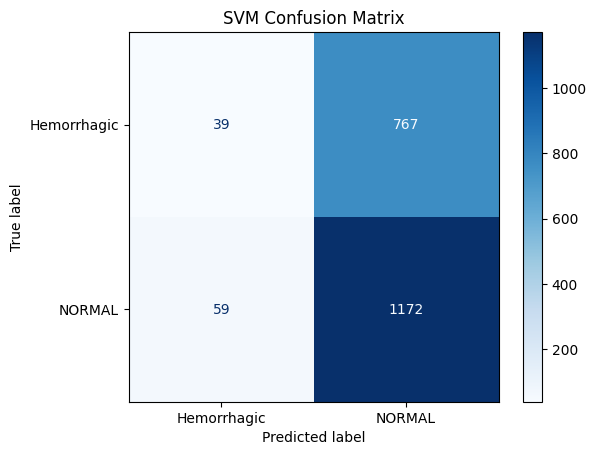

In [12]:
# Visualization
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_generator.class_indices)
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()


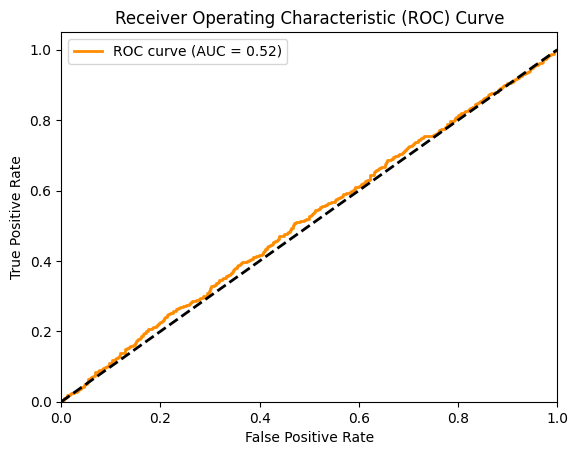

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# If you are using binary labels, you might need probabilities instead of labels for ROC
y_proba = svm_model.decision_function(X_val)  # Decision function output for ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="upper left")
plt.show()

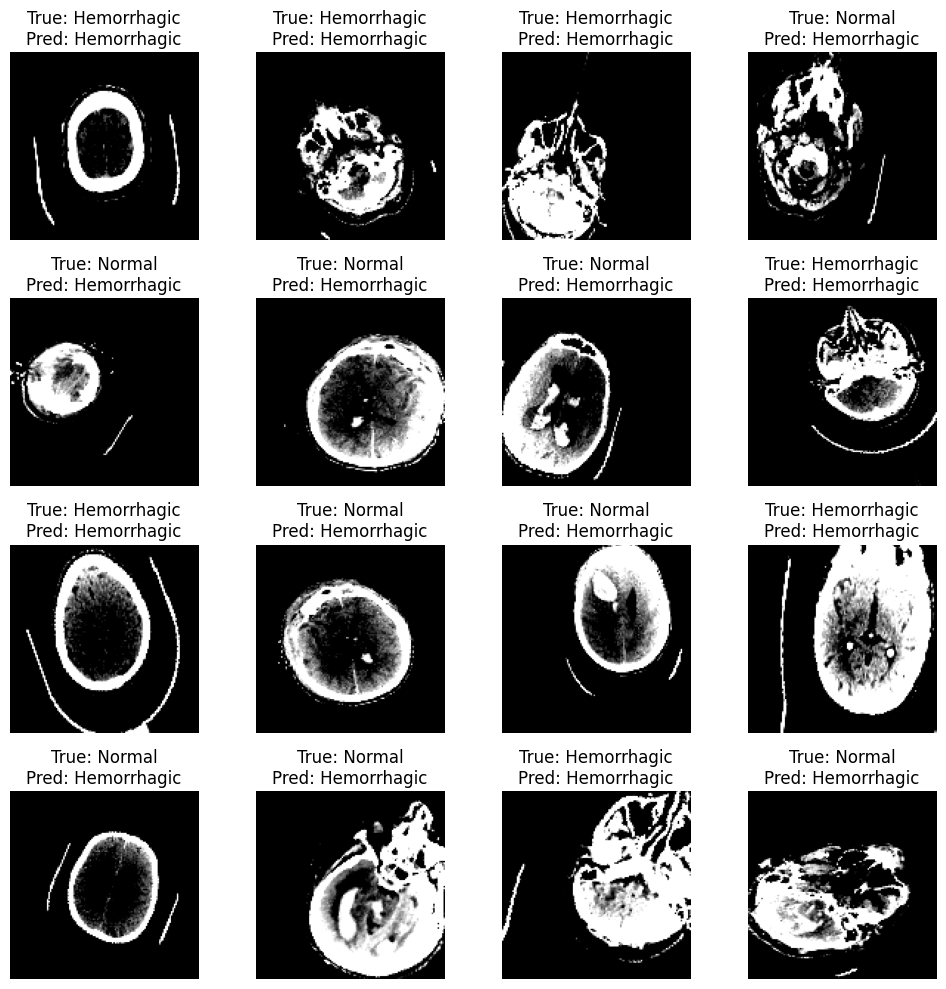

In [11]:
import matplotlib.pyplot as plt
import random

# Number of rows and columns for the grid
rows, cols = 4, 4

# Set the overall figure size
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Randomly select images from validation set and show predictions in the title
for i in range(rows * cols):  # 16 images in a 4x4 grid
    idx = random.randint(0, len(X_val) - 1)
    img = X_val[idx].reshape(128, 128, 3)  # Reshape if necessary
    label = y_val[idx]
    pred = y_pred[idx]

    # Get the subplot axis
    ax = axes[i // cols, i % cols]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {'Hemorrhagic' if label == 1 else 'Normal'}\nPred: {'Hemorrhagic' if pred == 1 else 'Normal'}")
    ax.axis('off')  # Turn off axis labels

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
